In [1]:
import json

from IPython.core.display import HTML
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Bidirectional, Dense, Embedding, GRU, Input, Lambda, Multiply, Softmax, TimeDistributed
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.utils import plot_model
tf.random.set_seed(54) # for consistent reproduction

In [18]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

In [2]:
data_train = np.load('data/data_train.npy')
data_val = np.load('data/data_val.npy')
data_test = np.load('data/data_test.npy')
labels_categorical_train = np.load('data/labels_categorical_train.npy')
labels_categorical_val = np.load('data/labels_categorical_val.npy')
labels_categorical_test = np.load('data/labels_categorical_test.npy')
EMBEDDING_WEIGHTS = np.load('data/embedding_weights.npy')

NUM_CLASSES = labels_categorical_train.shape[1]
MAX_NUM_VOCAB, EMBEDDING_DIM = EMBEDDING_WEIGHTS.shape
MAX_NUM_SENTS, MAX_NUM_WORDS_IN_SENT = data_train.shape[1:]
GRU_OUTPUT_DIM = 50
HIDDEN_STATES_DIM = GRU_OUTPUT_DIM*2

In [3]:
print('training   data and labels:', data_train.shape, labels_categorical_train.shape)
print('validation data and labels:', data_val.shape, labels_categorical_val.shape)
print('test       data and labels:', data_test.shape, labels_categorical_test.shape)
print('MAX_NUM_VOCAB             :', MAX_NUM_VOCAB)
print('EMBEDDING_DIM             :', EMBEDDING_DIM)
print('MAX_NUM_SENTS             :', MAX_NUM_SENTS)
print('MAX_NUM_WORDS_IN_SENT     :', MAX_NUM_WORDS_IN_SENT)

training   data and labels: (15750, 80, 85) (15750, 2)
validation data and labels: (1750, 80, 85) (1750, 2)
test       data and labels: (7500, 80, 85) (7500, 2)
MAX_NUM_VOCAB             : 20000
EMBEDDING_DIM             : 200
MAX_NUM_SENTS             : 80
MAX_NUM_WORDS_IN_SENT     : 85


In [4]:
def plot_model_loss_and_accuracy(history): 
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4), dpi=80) 
    ax1.plot(history.history['loss'], label='training') 
    ax1.plot(history.history['val_loss'], label='validaton') 
    ax1.axvline(np.argmin(history.history['val_loss']), color='purple', label='min val loss', linestyle='--') 
    ax1.set_title('model loss') 
    ax1.set_xlabel('epoch')
    ax1.set_xticks(history.epoch) 
    ax1.set_xticklabels([str(i+1) for i in history.epoch]) 
    ax1.set_ylabel('loss') 
    ax1.legend() 
    ax1.grid() 

    ax2.plot(history.history['accuracy'], label='training') 
    ax2.plot(history.history['val_accuracy'], label='validaton') 
    ax2.axvline(np.argmax(history.history['val_accuracy']), color='purple', label='max val ace', linestyle='--')
    ax2.set_title('model accuracy') 
    ax2.set_xlabel('epoch') 
    ax2.set_xticks(history.epoch) 
    ax2.set_xticklabels([str(i+1) for i in history.epoch]) 
    ax2.set_ylabel('accuracy')
    ax2.legend()
    ax2.grid()

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus: 
    for gpu in gpus: # memory growth needs to be the same across GPUs
        tf.config.experimental.set_memory_growth(gpu, True) 
display(gpus, tf.test.is_built_with_cuda()) 

[]

False

### build Word Encoder 

In [6]:
def word_encoder(name):   
    # ----- word encoder ----- 
    sentence_input = Input(shape=(MAX_NUM_WORDS_IN_SENT,), name='encoded_sentence') 
    words_vectors = Embedding(input_dim=MAX_NUM_VOCAB, output_dim=EMBEDDING_DIM, weights=[EMBEDDING_WEIGHTS], 
                              input_length=MAX_NUM_WORDS_IN_SENT, 
                              mask_zero=False, trainable=True, name='words_vectors')(sentence_input) 
    h_it = Bidirectional(GRU(GRU_OUTPUT_DIM, return_sequences=True), name='words_annotations')(words_vectors) # shape: [botch_size, num_words_in_sent, hidden_states_dim]
    # ----- word_attention -----
    u_it = Dense(HIDDEN_STATES_DIM, activation='tanh', name='hidden_representation_of_words_annotations')(h_it) # shape: [batch_size, num_words_in_sent, hidden_states_dim]
    alpha_it = Softmax(axis=1, name='normalized_words_importance_weights')(Dense(1, use_bias=False, name='context_vector')(u_it)) # shape: [batch_size, num_words_in_sent, 1] 
    s_i = Lambda(lambda x: K.sum(x, axis=1), name='sum_of_weighted_words_annotations')(Multiply(name='weighted_words_annotations')([alpha_it, h_it])) # shape: [batch_size, hidden_states_dim] 
    return Model(sentence_input, s_i, name=name) 

test = word_encoder('word_encoder')
plot_model(test, to_file='data/word_encoder.png', show_shapes=True, dpi=100) 
test.summary(line_length=160) 

Model: "word_encoder"
________________________________________________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape                        Param #            Connected to                                         
encoded_sentence (InputLayer)                       [(None, 85)]                        0                                                                       
________________________________________________________________________________________________________________________________________________________________
words_vectors (Embedding)                           (None, 85, 200)                     4000000            encoded_sentence[0][0]                               
________________________________________________________________________________________________________________________________________________________________
words_annota

### build Hierarchical Attention Network

In [7]:
def build_model(): 
    # -----= sentence encoder -----
    sentences_input = Input(shape=(MAX_NUM_SENTS, MAX_NUM_WORDS_IN_SENT), batch_size=None, dtype='int32', name='encoded_sentences') 
    words_attentions = TimeDistributed(word_encoder(name='word_encoders'), name='words_attentions')(sentences_input) 
    h_i = Bidirectional(GRU(GRU_OUTPUT_DIM, return_sequences=True), name='sentences_annotations')(words_attentions) # shape: [batch size, num_sents, hidden_dim_size]
    # ----- sentence attention -----
    u_i = Dense(HIDDEN_STATES_DIM, activation='tanh', name='hidden_representation_of_sentences_annotations')(h_i) # shape: [batch_size, num_sents, hidden_states_dim]
    alpha_i = Softmax(axis=1, name='normalized_sentences_importance_weights')(Dense(1, use_bias=False, name='sentences_context_vector')(u_i)) # shape: [batch size, num_sents, 1]
    v = Lambda(lambda x: K.sum(x, axis=1), name='sum_of_weighted_sentences_annotations')(Multiply(name='weighted_sentences_annotations')([alpha_i, h_i])) # shape: [batch_size, hidden_states_dim]
    # ----- document cLassification -----
    class_prediction = Dense(NUM_CLASSES, activation='softmax', name='classifier')(v)
    model = Model(sentences_input, class_prediction, name='hierarchical_attention_network')
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3, amsgrad=True), metrics=['accuracy']) 
    return model
                                                                               
hierarchical_attention_network = build_model() 
plot_model(hierarchical_attention_network, to_file='data/hierarchical_attention_network.png', show_shapes=True, dpi=100)
hierarchical_attention_network.summary(line_length=180)

Model: "hierarchical_attention_network"
____________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                               Output Shape                            Param #              Connected to                                                
encoded_sentences (InputLayer)                             [(None, 80, 85)]                        0                                                                                
____________________________________________________________________________________________________________________________________________________________________________________
words_attentions (TimeDistributed)                         (None, 80, 100)                         4085800              encoded_sentences[0][0]                                     
_______________________________________________________

### train model

In [8]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=2), 
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2), 
    ModelCheckpoint('model.{epoch:02d}-{val_loss:.3f}.h5', monitor='val_accuracy', save_best_only=True), 
    TensorBoard(log_dir='logs', update_freq='batch')
]

history = hierarchical_attention_network.fit(x=data_train, y=labels_categorical_train,
                                             validation_data=(data_val, labels_categorical_val), shuffle=True, 
                                             batch_size=64, epochs=10, callbacks=callbacks, verbose=1) 

Epoch 1/10
247/247 [==============================] - 1194s 5s/step - loss: 0.3985 - accuracy: 0.8005 - val_loss: 0.2851 - val_accuracy: 0.8811 - lr: 0.0010
Epoch 2/10
247/247 [==============================] - 1630s 7s/step - loss: 0.1912 - accuracy: 0.9280 - val_loss: 0.2804 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 3/10
247/247 [==============================] - 1557s 6s/step - loss: 0.0952 - accuracy: 0.9667 - val_loss: 0.3135 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 4/10
247/247 [==============================] - 1031s 4s/step - loss: 0.0348 - accuracy: 0.9893 - val_loss: 0.3678 - val_accuracy: 0.8937 - lr: 0.0010
Epoch 5/10
247/247 [==============================] - 1071s 4s/step - loss: 0.0125 - accuracy: 0.9967 - val_loss: 0.4292 - val_accuracy: 0.9006 - lr: 0.0010


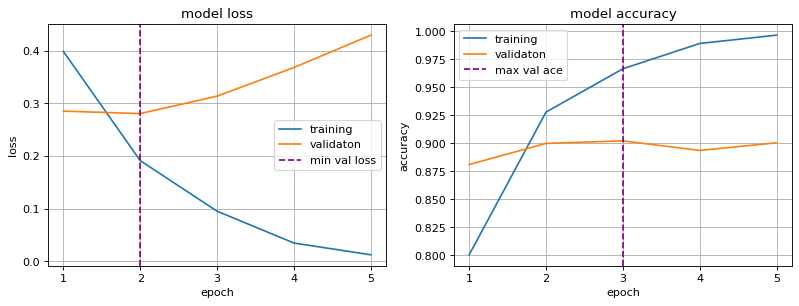

In [9]:
plot_model_loss_and_accuracy(history)

In [ ]:
# %tensorboard --logdir logs

In [10]:
test_loss, test_accuracy = hierarchical_attention_network.evaluate(data_test, labels_categorical_test, verbose=0) 
print('test loss: {:.3f}, test accuracy: {:.3f}'.format(test_loss, test_accuracy))

test loss: 0.454, test accuracy: 0.899


In [11]:
hierarchical_attention_network.save(f'model_{MAX_NUM_SENTS}_{MAX_NUM_WORDS_IN_SENT}.h5')

### evaluate model

In [12]:
model_loaded = load_model(f'model_{MAX_NUM_SENTS}_{MAX_NUM_WORDS_IN_SENT}.h5', custom_objects={'Functional': Model})

In [13]:
get_sentences_attentions = K.function(model_loaded.input, model_loaded.get_layer('normalized_sentences_importance_weights').output)
get_words_attentions = K.function(model_loaded.get_layer('words_attentions').layer.input, 
                                  model_loaded.get_layer('words_attentions').layer.get_layer('normalized_words_importance_weights').output)

print(get_sentences_attentions(data_train[0][np.newaxis, :])[0].shape, get_words_attentions(data_train[0]).shape) 

(80, 1) (80, 85, 1)


In [17]:
document_index = np.random.randint(low=0, high=len(data_test)-1) # pick a random document index 
document_encoded = data_test[document_index]

with open('data/tokenizer.json', 'r') as f: 
    tokenizer = tokenizer_from_json(json.load(f)) 

word_attention_scale_factor = 1 
sentence_attention_scale_factor = 3

visualized_document = [] 
for sentence_index, sentence_encoded in enumerate(document_encoded): 
    highlighted_sentence = []
    if sum(sentence_encoded) > 0: # retrieve non-empty sentences only 
        # retrieve word attention_pairs per sentence 
        for (word_encoded, word_attention) in zip(sentence_encoded, get_words_attentions(document_encoded)[sentence_index]):
            if 0 < word_encoded < MAX_NUM_VOCAB:
                highlighted_sentence.append('<span style="background-color:rgba(135,206,250,' + str(word_attention[0]*word_attention_scale_factor) + ');">' + tokenizer.index_word[word_encoded] + '</span>')
        # retrieve attention per sentence
        sentence_attention = get_sentences_attentions(document_encoded[np.newaxis, :])[0][sentence_index][0]
        sentence_attention_head = '<span style="background-color:rgba(255,0,0,' + str(sentence_attention*sentence_attention_scale_factor) + ');">' + '&nbsp;'*3 + f'{sentence_index:02}' + '&nbsp;'*3 + '</span>'
        visualized_document.append(sentence_attention_head + ' '.join(highlighted_sentence)) 
visualized_document = '<br />'.join(visualized_document)
HTML(visualized_document)

In [15]:
# translate one-hot encoded (categorical) labels to one dimension
index_label_dict = np.load('data/index_label_dict.npy', allow_pickle=True)[()]
labels_categorical_pred = model_loaded.predict(data_test)
labels_pred = [index_label_dict[i] for i in labels_categorical_pred.argmax(axis=1)]
labels_test = [index_label_dict[i] for i in labels_categorical_test.argmax(axis=1)]
print(classification_report(y_true=labels_test, y_pred=labels_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3750
           1       0.90      0.90      0.90      3750

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.90      7500
weighted avg       0.90      0.90      0.90      7500

